In [1]:
import pandas as pd

In [2]:
path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
data = pd.read_csv(path)

In [3]:
data_t = data.T
data_t.columns = data_t.iloc[1, :].astype(str) + '_' +  data_t.iloc[0, :].astype(str)
data_t = data_t.iloc[4:]
data_t = data_t.reset_index()
data_t['date'] = pd.to_datetime(data_t['index'])
data_t.columns = data_t.columns.str.replace(" ","_")
data_t.columns = data_t.columns.str.replace(",","_")
data_t = data_t.drop(['index', ], axis=1)
data_t = data_t.set_index('date')

In [4]:
data_china = data[data['Country/Region'] == 'Mainland China'].T
data_china = data_china.sum(axis=1)
data_china = data_china.iloc[4:]
data_china = data_china.rename('China_total')

In [5]:
data_all= pd.concat([data_t, data_china], axis=1)
melted = pd.melt(data_all)
size = len(melted['variable'].unique())
index = ([data_all.index.to_list()] * size)
flat_index = [item for sublist in index for item in sublist]
full_df = pd.concat([melted, pd.DataFrame(flat_index, columns=['date'])], axis=1)
full_df.to_csv('corona_confirmed_formated.csv', index=False)
full_df.head()

,variable,value,date
0,Mainland_China_Anhui,1,2020-01-22
1,Mainland_China_Anhui,9,2020-01-23
2,Mainland_China_Anhui,15,2020-01-24
3,Mainland_China_Anhui,39,2020-01-25
4,Mainland_China_Anhui,60,2020-01-26


## Automaticaly fit sigmoid

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid")
sns.set_style("ticks")


In [7]:
non_china_non_cruise = ['Thailand_nan', 'Japan_nan',
       'South_Korea_nan', 'Taiwan_Taiwan', 'US_Seattle__WA',
       'US_Chicago__IL', 'US_Tempe__AZ', 'Macau_Macau',
       'Hong_Kong_Hong_Kong', 'Singapore_nan', 'Vietnam_nan',
       'France_nan', 'Nepal_nan', 'Malaysia_nan', 'Canada_Toronto__ON',
       'Canada_British_Columbia', 'US_Orange__CA', 'US_Los_Angeles__CA',
       'Australia_New_South_Wales', 'Australia_Victoria',
       'Australia_Queensland', 'Cambodia_nan', 'Sri_Lanka_nan',
       'Germany_nan', 'Finland_nan', 'United_Arab_Emirates_nan',
       'Philippines_nan', 'India_nan', 'Canada_London__ON', 'Italy_nan',
       'UK_nan', 'Russia_nan', 'Sweden_nan', 'US_Santa_Clara__CA',
       'Spain_nan', 'Australia_South_Australia', 'US_Boston__MA',
       'US_San_Benito__CA', 'Belgium_nan', 'US_Madison__WI',
       'US_San_Diego_County__CA',
       'US_San_Antonio__TX', 'Egypt_nan', 'US_Omaha__NE']

non_hubei = ['Mainland_China_Anhui', 'Mainland_China_Beijing',
       'Mainland_China_Chongqing', 'Mainland_China_Fujian',
       'Mainland_China_Gansu', 'Mainland_China_Guangdong',
       'Mainland_China_Guangxi', 'Mainland_China_Guizhou',
       'Mainland_China_Hainan', 'Mainland_China_Hebei',
       'Mainland_China_Heilongjiang', 'Mainland_China_Henan',
        'Mainland_China_Hunan',
       'Mainland_China_Inner_Mongolia', 'Mainland_China_Jiangsu',
       'Mainland_China_Jiangxi', 'Mainland_China_Jilin',
       'Mainland_China_Liaoning', 'Mainland_China_Ningxia',
       'Mainland_China_Qinghai', 'Mainland_China_Shaanxi',
       'Mainland_China_Shandong', 'Mainland_China_Shanghai',
       'Mainland_China_Shanxi', 'Mainland_China_Sichuan',
       'Mainland_China_Tianjin', 'Mainland_China_Tibet',
       'Mainland_China_Xinjiang', 'Mainland_China_Yunnan',
       'Mainland_China_Zhejiang', ]

hubei = ['Mainland_China_Hubei']

cruise = ['Others_Diamond_Princess_cruise_ship']

def get_X_vector(df, columns):
    X = full_df[full_df['variable'].isin(columns)]
    X = X.set_index('date')
    X = X.resample('D').sum()['value']
    return X.values

X_non_hubei = get_X_vector(full_df, non_hubei)
X_non_china_non_cruise = get_X_vector(full_df, non_china_non_cruise)
X_hubei = get_X_vector(full_df, hubei)
X_cruise = get_X_vector(full_df, cruise)

In [31]:
import numpy
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
from matplotlib import dates


class SimoidOptimizer():

    def __init__(self, yData, number_of_days_to_predict, title='', test_days=2, start_date = '2020-01-22', *kwargs):
        self.yData = yData
        self.xData = np.linspace(0, len(self.yData), len(self.yData+1))
        self.number_of_days = number_of_days_to_predict
        self.title = title
        self.test_days = test_days
        self.start_date = start_date
        

    def sigmoid(self, x, amplitude, x0, k):
        return amplitude * 1.0/(1.0+numpy.exp(-x0*(x-k)))

    def sumOfSquaredError(self, parameterTuple):
        # function for genetic algorithm to minimize (sum of squared error)
        # do not print warnings by genetic algorithm
        warnings.filterwarnings("ignore")
        val = self.sigmoid(self.xData, *parameterTuple)
        return numpy.sum((self.yData - val) ** 2.0)

    def generate_Initial_Parameters(self):
        # min and max used for bounds
        maxX = max(self.xData)
        minX = min(self.xData)
        maxY = max(self.yData)
        minY = min(self.yData)

        parameterBounds = []
        parameterBounds.append([minY, maxY])  # search bounds for amplitude
        parameterBounds.append([minX, maxX])  # search bounds for x0
        parameterBounds.append([minX, maxX])  # search bounds for k

        # "seed" the numpy random number generator for repeatable results
        result = differential_evolution(
            self.sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    def fit(self):
        # by default, differential_evolution completes by calling curve_fit() using parameter bounds
        geneticParameters = self.generate_Initial_Parameters()

        # now call curve_fit without passing bounds from the genetic algorithm,
        # just in case the best fit parameters are aoutside those bounds
        self.fittedParameters, pcov = curve_fit(self.sigmoid, self.xData[:-self.test_days],
                                                self.yData[:-self.test_days], geneticParameters)
        
        print('Fitted parameters:', self.fittedParameters)

        modelPredictions = self.sigmoid(self.xData, *self.fittedParameters)
        

        absError = modelPredictions - self.yData
        SE = numpy.square(absError)  # squared errors
        MSE = numpy.mean(SE)  # mean squared errors
        RMSE = numpy.sqrt(MSE)  # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (numpy.var(absError) / numpy.var(self.yData))
        print('RMSE:', RMSE)
        print('R-squared:', Rsquared)

    def predict(self):
        xModel = numpy.linspace(0, self.number_of_days, self.number_of_days+1)
        
        yModel = self.sigmoid(xModel, *self.fittedParameters)
        index_sig = pd.date_range(self.start_date, periods=self.number_of_days+1)
        model = pd.Series(yModel)
        model.index = index_sig

        actual_cases = pd.Series(self.yData[:-self.test_days])
        index_actual = pd.date_range(
            self.start_date, periods=len(self.yData[:-self.test_days]))
        actual_cases.index = index_actual

        non_trained_cases = pd.Series(self.yData[-self.test_days:])
        start_non_trained = (
            index_actual[-1] + pd.Timedelta(1, 'D')).strftime("%Y-%m-%d")
        index_non_trained = pd.date_range(
            start_non_trained, periods=self.test_days)
        non_trained_cases.index = index_non_trained

        self.non_trained_cases = non_trained_cases
        self.actual_cases = actual_cases
        self.model = model

    def ModelAndScatterPlot(self):
        # now the model as a line plot
        ax = self.model.plot(figsize=(25, 10), linewidth=7, color='#65cccc', x_compat=True)

        # first the raw data as a scatter plot
        self.actual_cases.plot(style='o', ms=12, c='#ff0066', ax=ax)

        # non trained plot
        self.non_trained_cases.plot(style='o', ms=12, c='#002244ff', ax=ax)

        
        
        #ax.set_ylabel('confirmed cases\n', fontsize=30)  # Y axis data label
        #ax.set_title(self.title, fontsize=20)
        ax.legend(['simulation', 'actual used to train the model',
                   'actual after simulation date'], prop={'size': 25})

        # graphics output section
        plt.rcParams["figure.dpi"] = 300
        maxi_ax = max(max(self.model.values * 1.1), max(self.non_trained_cases.values)*1.1)
        ax.set_ylim((0, maxi_ax))
        
        # Set major ticks with month names
        ax.xaxis.set_major_locator(dates.MonthLocator(interval=5))
        ax.xaxis.set_major_formatter(dates.DateFormatter(''))
        ax.xaxis.set_minor_locator(dates.DayLocator(interval=9))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('\n%d %b'))
        
        ax.xaxis.grid(True, which='both')
        ax.yaxis.grid(True, which="major")
        
        ax.get_xaxis().set_tick_params(which='minor', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        
        plt.show()
        plt.close('all')  # clean up after using pyplot

        return ax


Fitted parameters: [8.15199303e+04 1.93333711e-01 2.14624114e+01]
RMSE: 2780.405299357317
R-squared: 0.9851617217390892


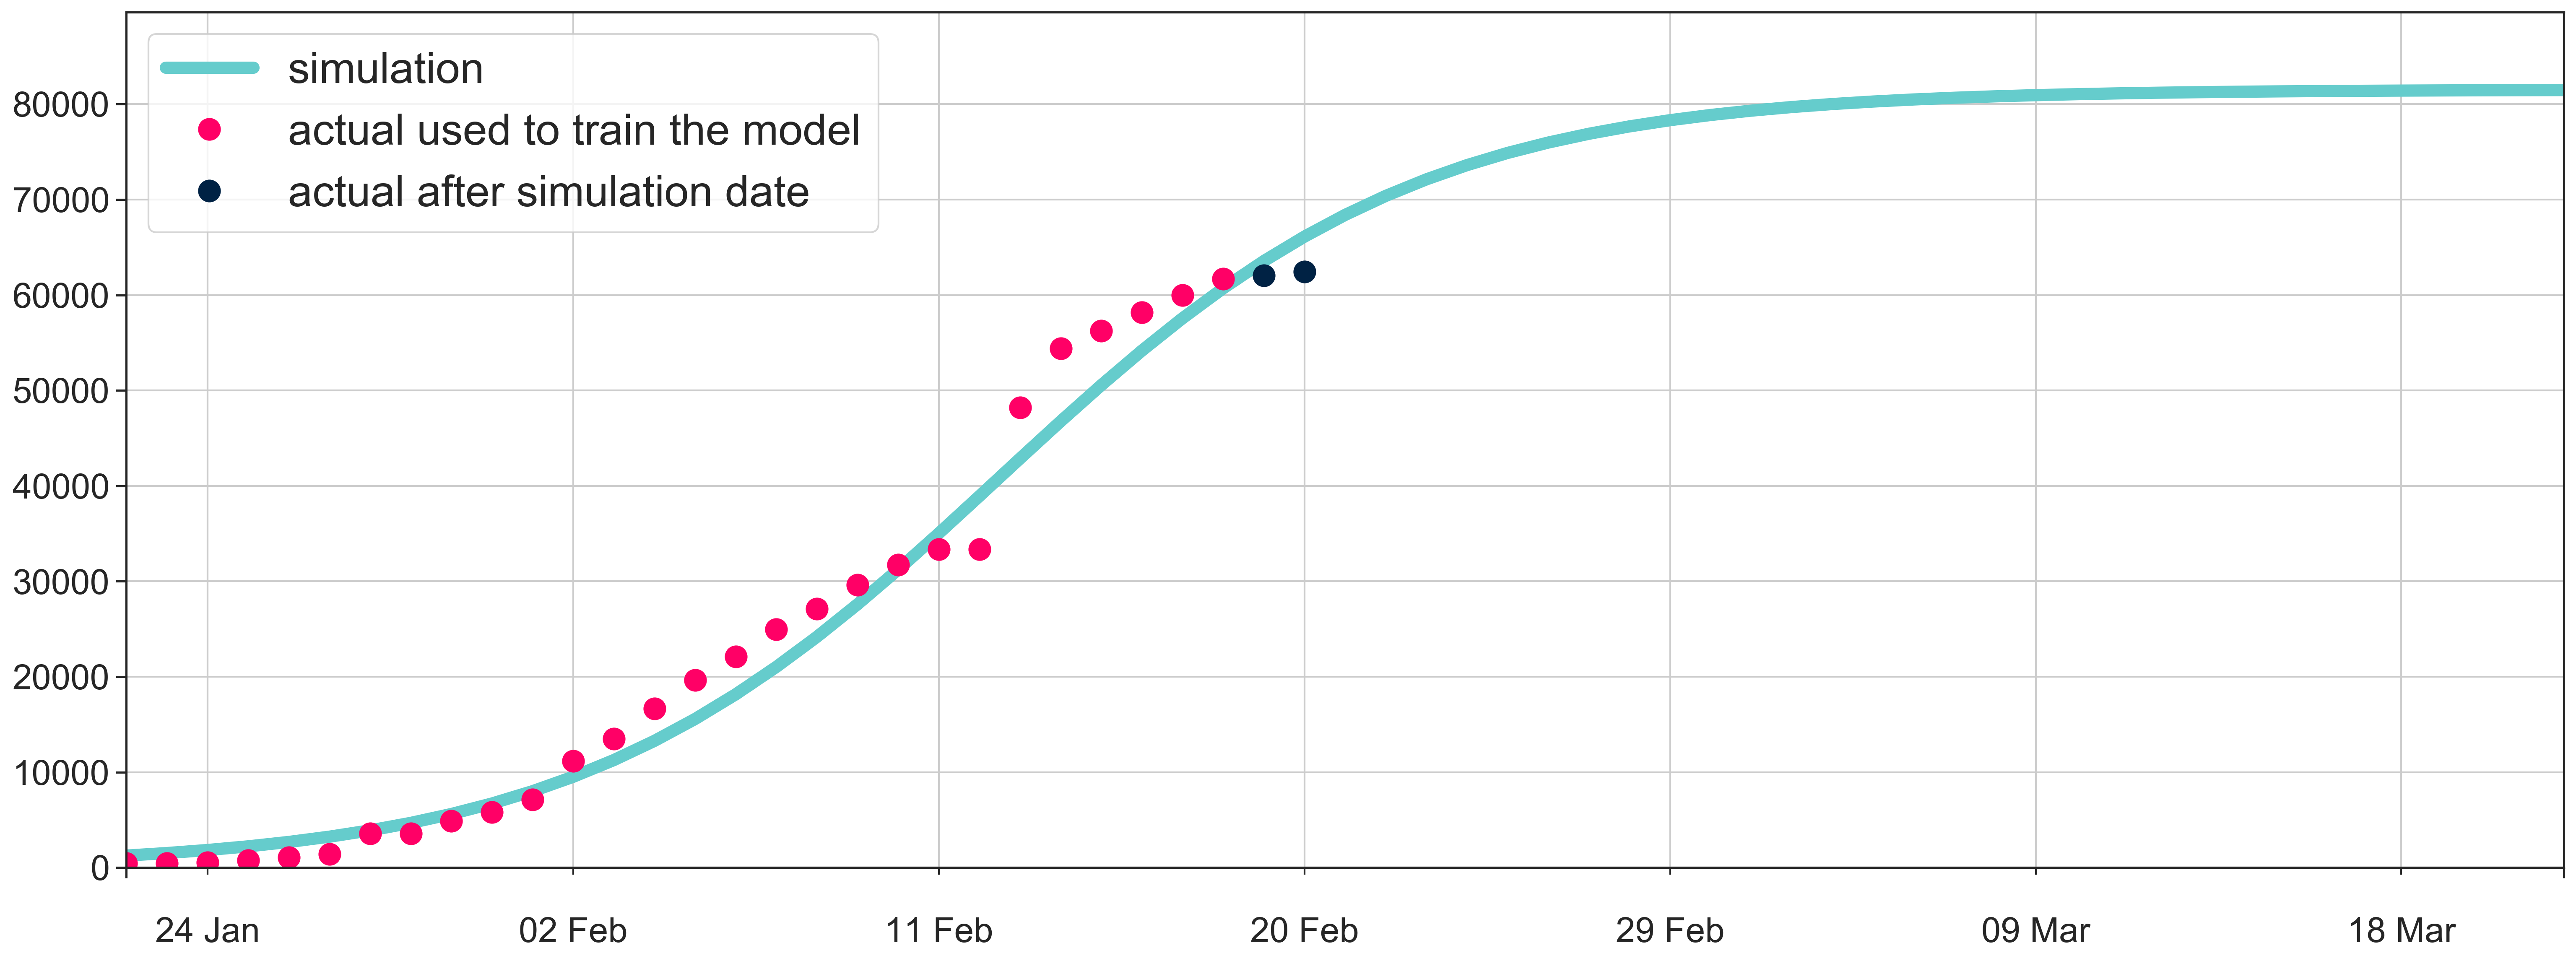

In [29]:
sig = SimoidOptimizer(X_hubei, 60, title='Hubei', test_days=2)
sig.fit()
sig.predict()
sig.ModelAndScatterPlot()

df_hubei = pd.concat([sig.model, sig.actual_cases, sig.non_trained_cases], axis=1)
df_hubei.columns = ['model', 'actual_case', 'non_trained_actual_case']
df_hubei.index.name = 'date'
df_hubei.to_csv('hubei_data.csv')

In [10]:
len(X_non_china_non_cruise)

30

In [11]:
len(X_hubei)

30

In [12]:
X = full_df[full_df['variable'].isin(non_china_non_cruise)]
X = X.set_index('date')
X = X.resample('D').sum()['value']

Fitted parameters: [4.85712482e+02 1.71751466e-01 1.53921610e+01]
RMSE: 25.093856033869653
R-squared: 0.9739671867187887


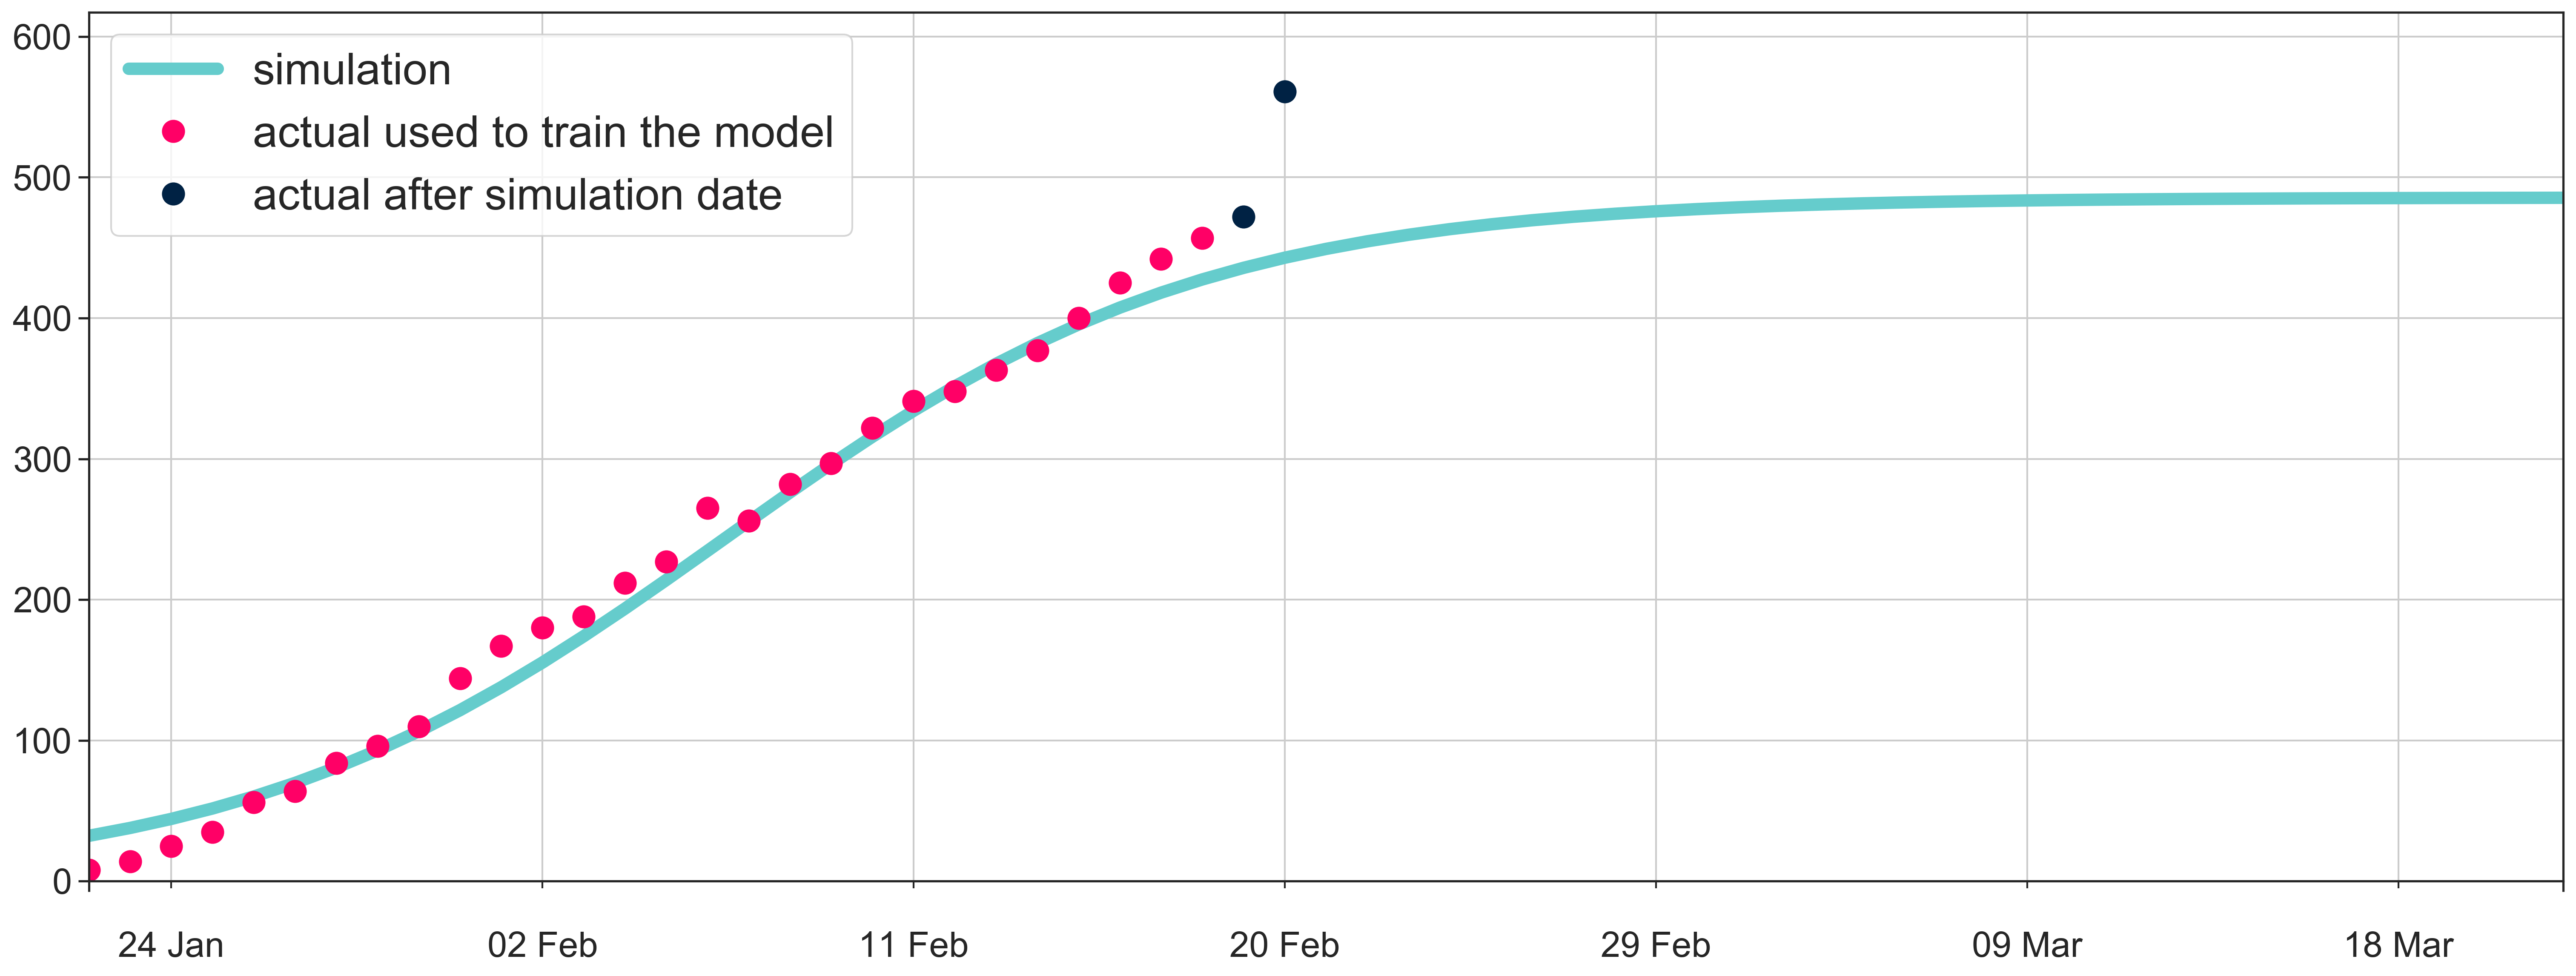

In [32]:
sig = SimoidOptimizer(X_non_china_non_cruise, number_of_days_to_predict=60, test_days=2)
sig.fit()
sig.predict()
sig.ModelAndScatterPlot()

df_non_china_non_cruise = pd.concat([sig.model, sig.actual_cases, sig.non_trained_cases], axis=1)
df_non_china_non_cruise.columns = ['model', 'actual_case', 'non_trained_actual_case']
df_non_china_non_cruise.index.name = 'date'
df_non_china_non_cruise.to_csv('non_china_non_cruise.csv')

Fitted parameters: [1.24985741e+04 2.60894297e-01 1.26089545e+01]
RMSE: 193.97778431583964
R-squared: 0.9981919912185546


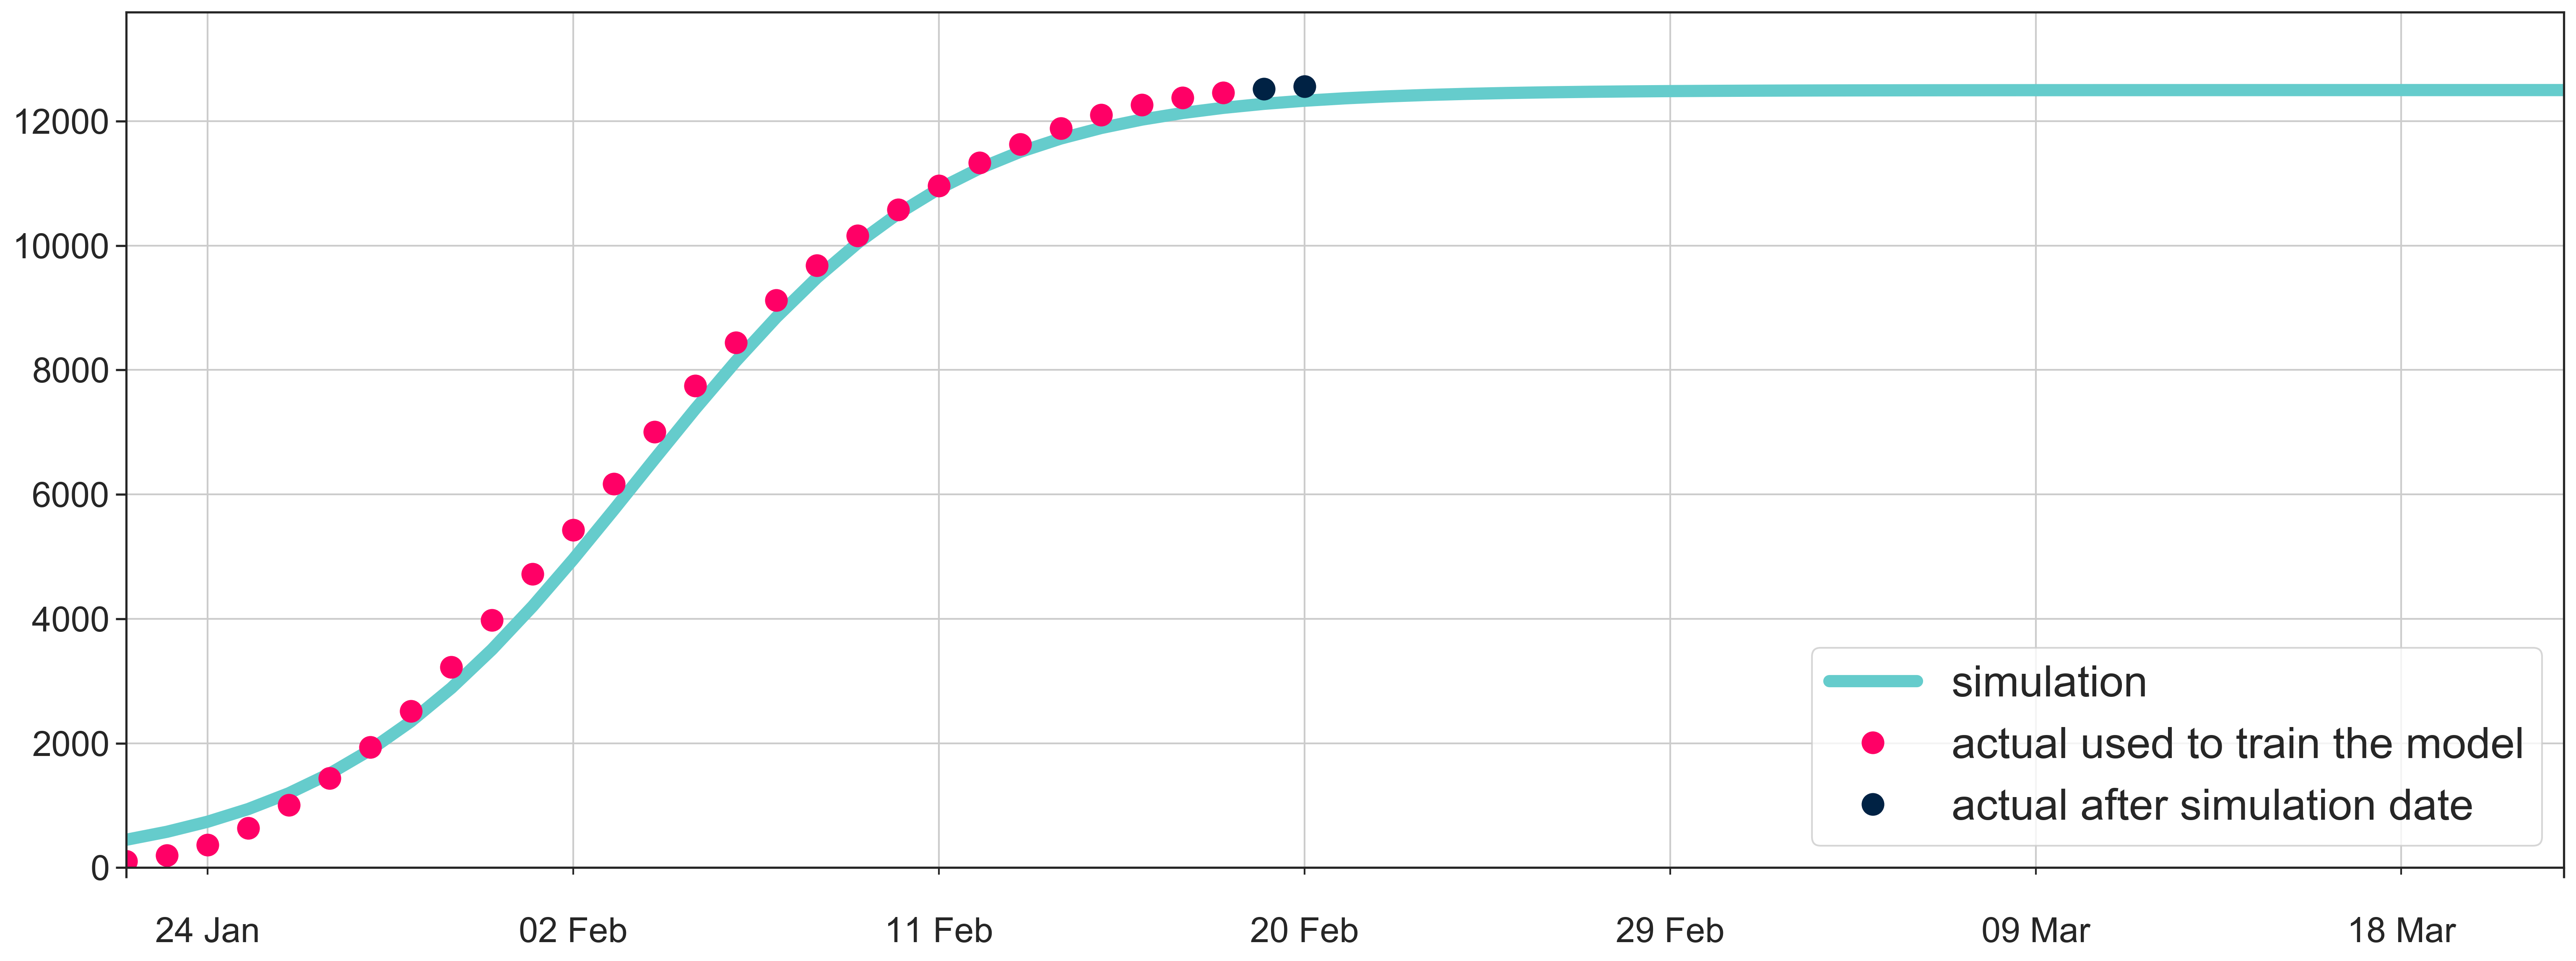

In [14]:
sig = SimoidOptimizer(X_non_hubei, number_of_days_to_predict=60, 
                      title = 'China, except Hubei', test_days=2)
sig.fit()
sig.predict()
sig.ModelAndScatterPlot()

df_non_hubei = pd.concat([sig.model, sig.actual_cases, sig.non_trained_cases], axis=1)
df_non_hubei.columns = ['model', 'actual_case', 'non_trained_actual_case']
df_non_hubei.index.name = 'date'
df_non_hubei.to_csv('China_non_hubei.csv')

Fitted parameters: [2.07381555e+03 2.39491683e-01 2.12449802e+01]
RMSE: 35.85805479932129
R-squared: 0.9737502834037312


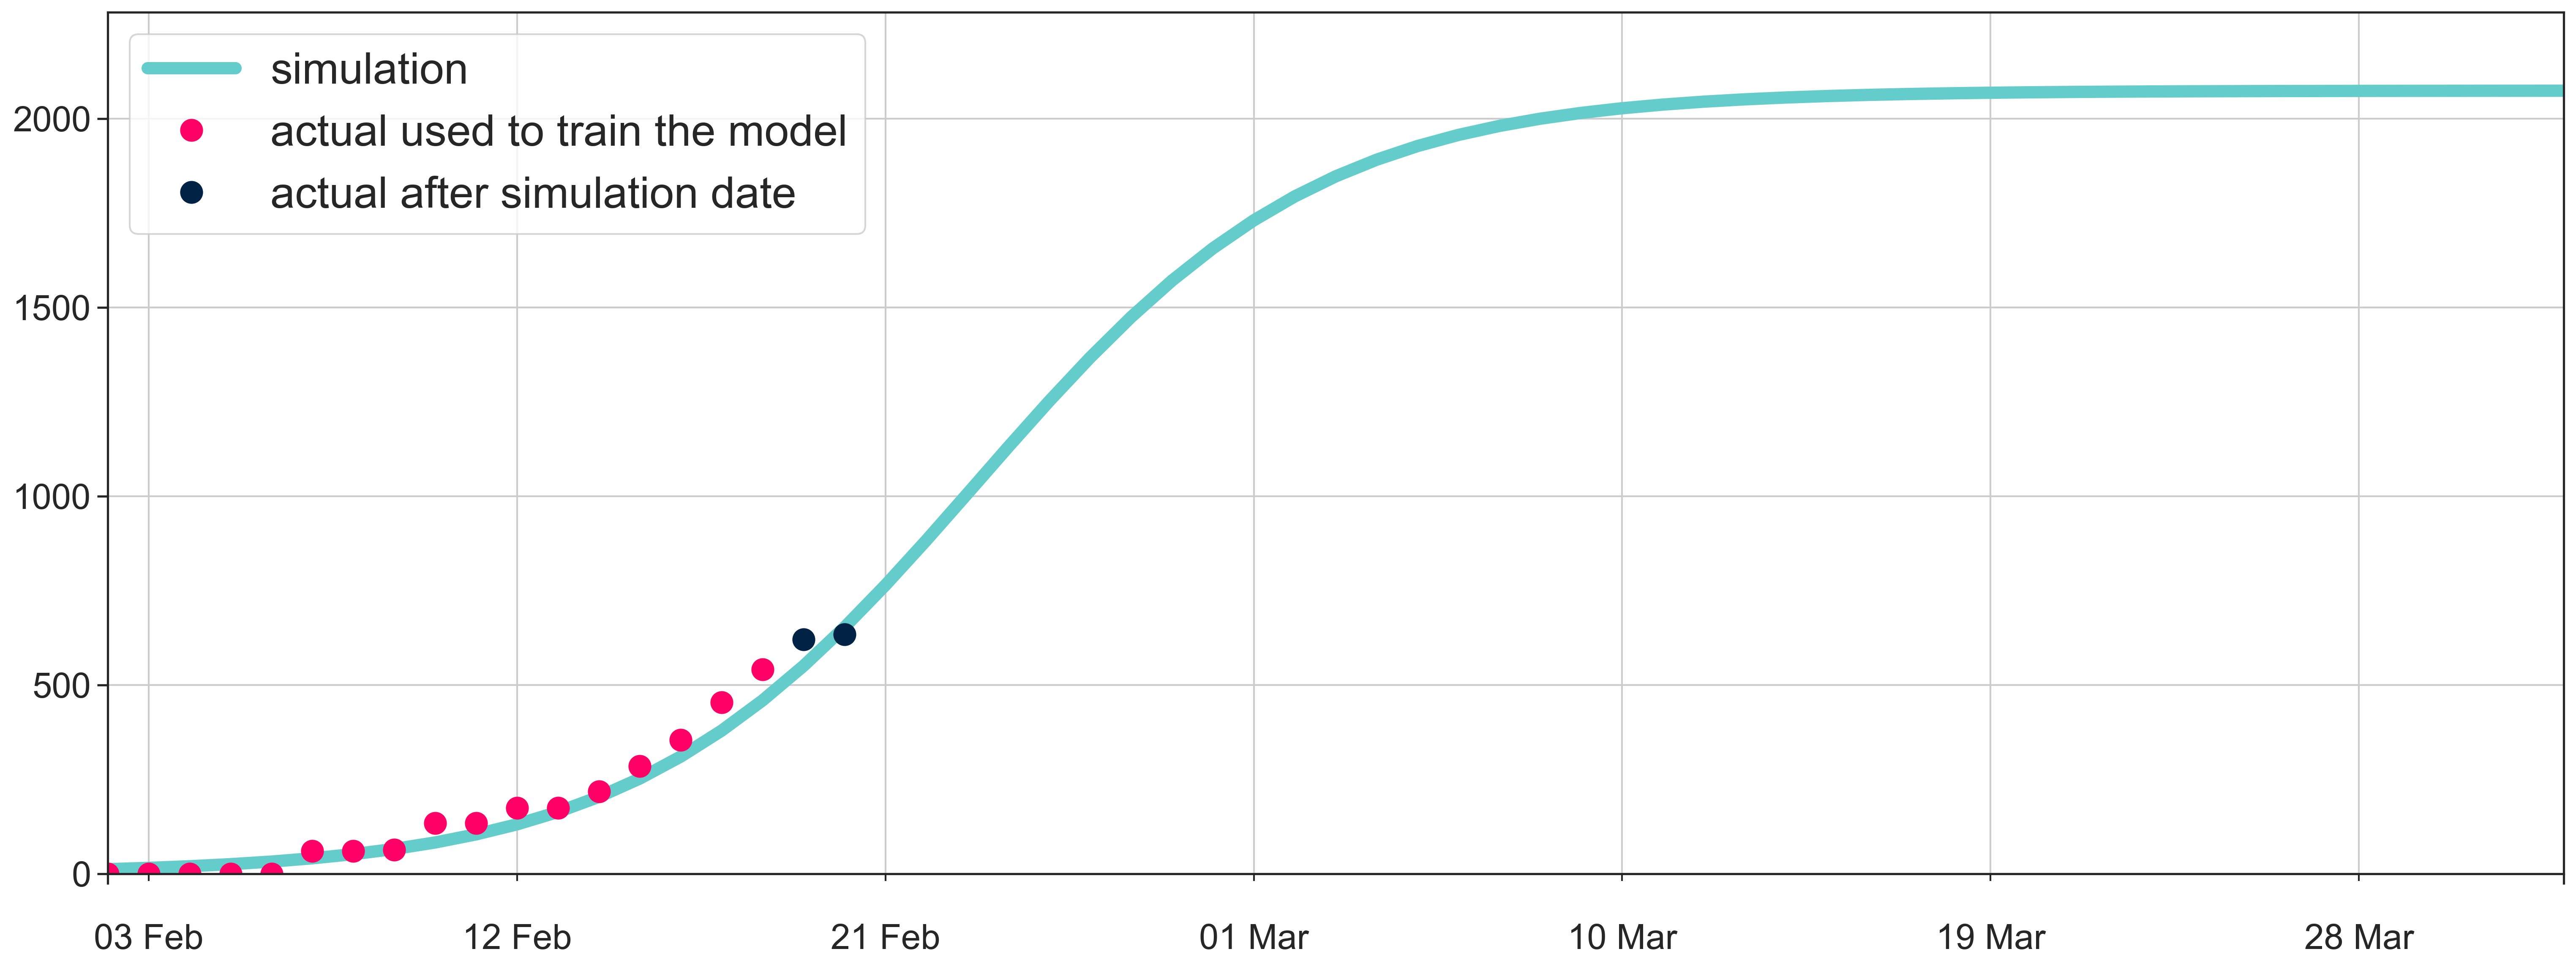

In [220]:
shift = 11
date = full_df[full_df['variable'] == 'Others_Diamond_Princess_cruise_ship'][shift:]['date'].iloc[0].strftime("%Y-%m-%d")
sig = SimoidOptimizer(X_cruise[shift:], number_of_days_to_predict=60, 
                      title = 'Diamond cruise', test_days=2, start_date=date)
sig.fit()
sig.predict()
sig.ModelAndScatterPlot()

df_cruise = pd.concat([sig.model, sig.actual_cases, sig.non_trained_cases], axis=1)
df_cruise.columns = ['model', 'actual_case', 'non_trained_actual_case']
df_cruise.index.name = 'date'
df_cruise.to_csv('cruise.csv')

In [87]:
sig.non_trained_cases

2020-02-18    542
2020-02-19    621
Freq: D, dtype: int64

In [88]:
sig.model

2020-01-22       0.633042
2020-01-23       0.817646
2020-01-24       1.056045
2020-01-25       1.363891
2020-01-26       1.761372
                 ...     
2020-03-18    1500.436756
2020-03-19    1500.913608
2020-03-20    1501.282962
2020-03-21    1501.569014
2020-03-22    1501.790531
Freq: D, Length: 61, dtype: float64

## Population region china

In [56]:
pop = pd.read_csv('population_china.csv', sep='	', thousands=',')

In [57]:
pop

,Region,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009
0,Beijing,30319.98,28014.94,25669.13,23014.59,21330.83,19800.81,17879.40,16251.93,14113.58,12153.03
1,Tianjin,18809.64,18549.19,17885.39,16538.19,15726.93,14442.01,12893.88,11307.28,9224.46,7521.85
2,Hebei,36010.27,34016.32,32070.45,29806.11,29421.15,28442.95,26575.01,24515.76,20394.26,17235.48
3,Shanxi,16818.11,15528.42,13050.41,12766.49,12761.49,12665.25,12112.83,11237.55,9200.86,7358.31
4,Inner Mongolia,17289.22,16096.21,18128.10,17831.51,17770.19,16916.50,15880.58,14359.88,11672.00,9740.25
5,Liaoning,25315.35,23409.24,22246.90,28669.02,28626.58,27213.22,24846.43,22226.70,18457.27,15212.49
6,Jilin,15074.62,14944.53,14776.80,14063.13,13803.14,13046.40,11939.24,10568.83,8667.58,7278.75
7,Heilongjiang,16361.62,15902.68,15386.09,15083.67,15039.38,14454.91,13691.58,12582.00,10368.60,8587.00
8,Shanghai,32679.87,30632.99,28178.65,25123.45,23567.70,21818.15,20181.72,19195.69,17165.98,15046.45
9,Jiangsu,92595.40,85869.76,77388.28,70116.38,65088.32,59753.37,54058.22,49110.27,41425.48,34457.30


In [58]:
pop = pop[['Region', '2018']]
pop.columns = ['Region', 'population']

In [61]:
china = data_t.columns[data_t.columns.str.startswith('Mainland_China')]
list_of_region = china.str.split('_', expand=True).to_list()
regions = [i[2] for i in list_of_region]
china_data = data_t[china]
regions[14] = 'Inner Mongolia'
china_data.columns = regions
for region in regions:
    china_data[region] = china_data[region]/ pop[pop['Region'] == region]['population'].values[0]

china_data = china_data.astype(float)

In [83]:
df = china_data

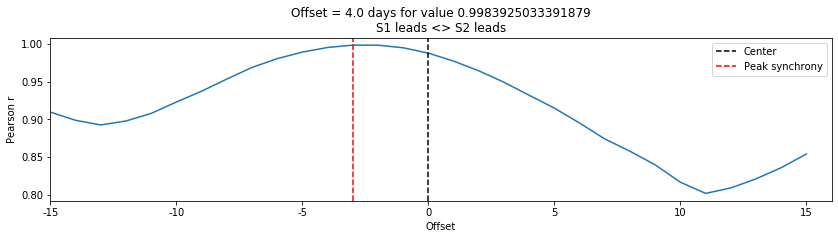

In [94]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['Jiangxi']
d2 = df['Heilongjiang']
day_range = 15
rs = [crosscorr(d1,d2, lag) for lag in range(-int(day_range),int(day_range+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.floor(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} days for value {np.max(rs)}\nS1 leads <> S2 leads',
       #ylim=[.1,.31],
       xlim=[0,31], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
ax.set_xticklabels([-15, -10, -5, 0, 5, 10, 15]);
plt.legend()

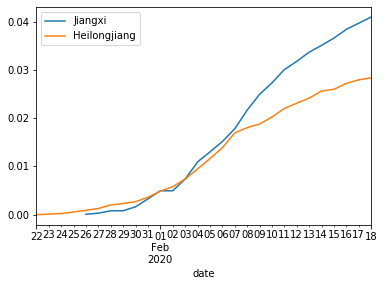

In [129]:
d1.shift(4).plot(legend=d1.name)
d2.plot(legend=d2.name)

In [404]:
## Others

# Manual fit of sigmoid

In [170]:
def sigmoid(X, lambda_t):
    return 1/(1+np.exp(-lambda_t*X))

## Non hubei

In [171]:
non_hubei = ['Mainland_China_Anhui', 'Mainland_China_Beijing',
       'Mainland_China_Chongqing', 'Mainland_China_Fujian',
       'Mainland_China_Gansu', 'Mainland_China_Guangdong',
       'Mainland_China_Guangxi', 'Mainland_China_Guizhou',
       'Mainland_China_Hainan', 'Mainland_China_Hebei',
       'Mainland_China_Heilongjiang', 'Mainland_China_Henan',
        'Mainland_China_Hunan',
       'Mainland_China_Inner_Mongolia', 'Mainland_China_Jiangsu',
       'Mainland_China_Jiangxi', 'Mainland_China_Jilin',
       'Mainland_China_Liaoning', 'Mainland_China_Ningxia',
       'Mainland_China_Qinghai', 'Mainland_China_Shaanxi',
       'Mainland_China_Shandong', 'Mainland_China_Shanghai',
       'Mainland_China_Shanxi', 'Mainland_China_Sichuan',
       'Mainland_China_Tianjin', 'Mainland_China_Tibet',
       'Mainland_China_Xinjiang', 'Mainland_China_Yunnan',
       'Mainland_China_Zhejiang', ]

In [172]:
X_non_hub = full_df[full_df['variable'].isin(non_hubei)]
X_non_hub= X_non_hub.set_index('date')

X_non_hub = X_non_hub.resample('D').sum()['value']

In [173]:
max_cases = 13000
day_range = 50

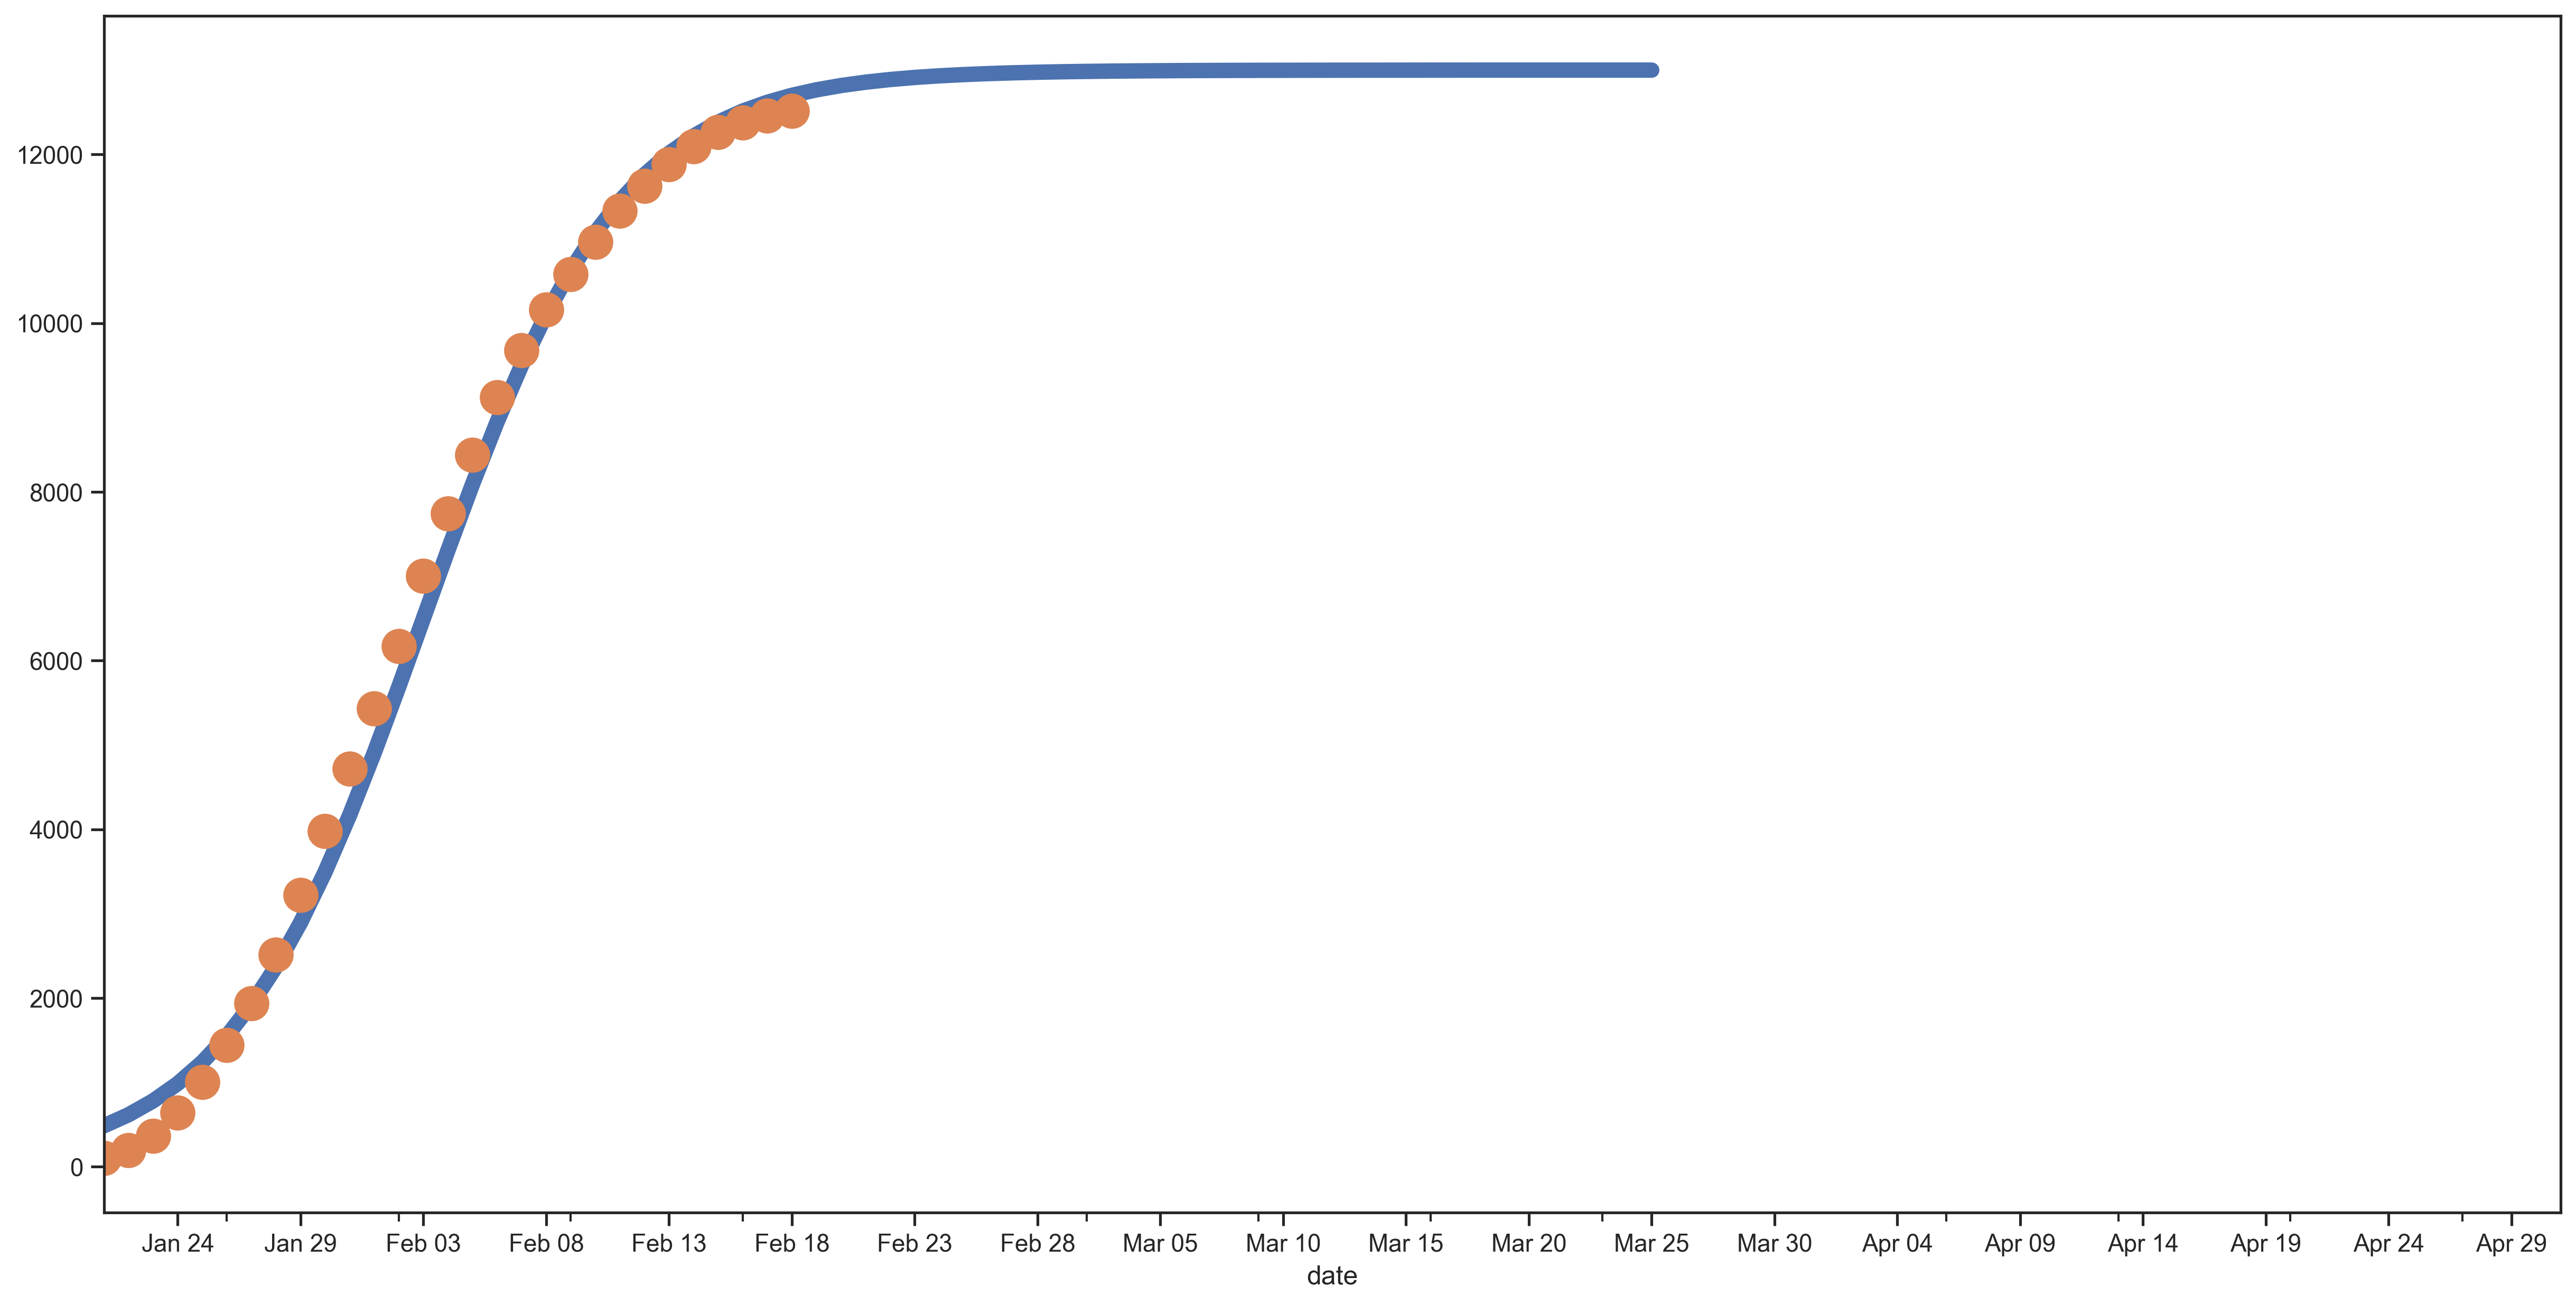

In [174]:
import matplotlib.dates as mdates
x = np.linspace(-day_range, day_range, day_range*2+1)
index_sig = pd.date_range('2020-01-22', periods= day_range*2+1)
X_sigmoid = pd.Series(sigmoid(x, 0.25) * max_cases)
X_sigmoid.index = index_sig
ax = X_sigmoid.shift(-37).plot(figsize=(20,10), linewidth=7)
X_non_hub.plot(style='o', ms=15)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#plt.gcf().autofmt_xdate()

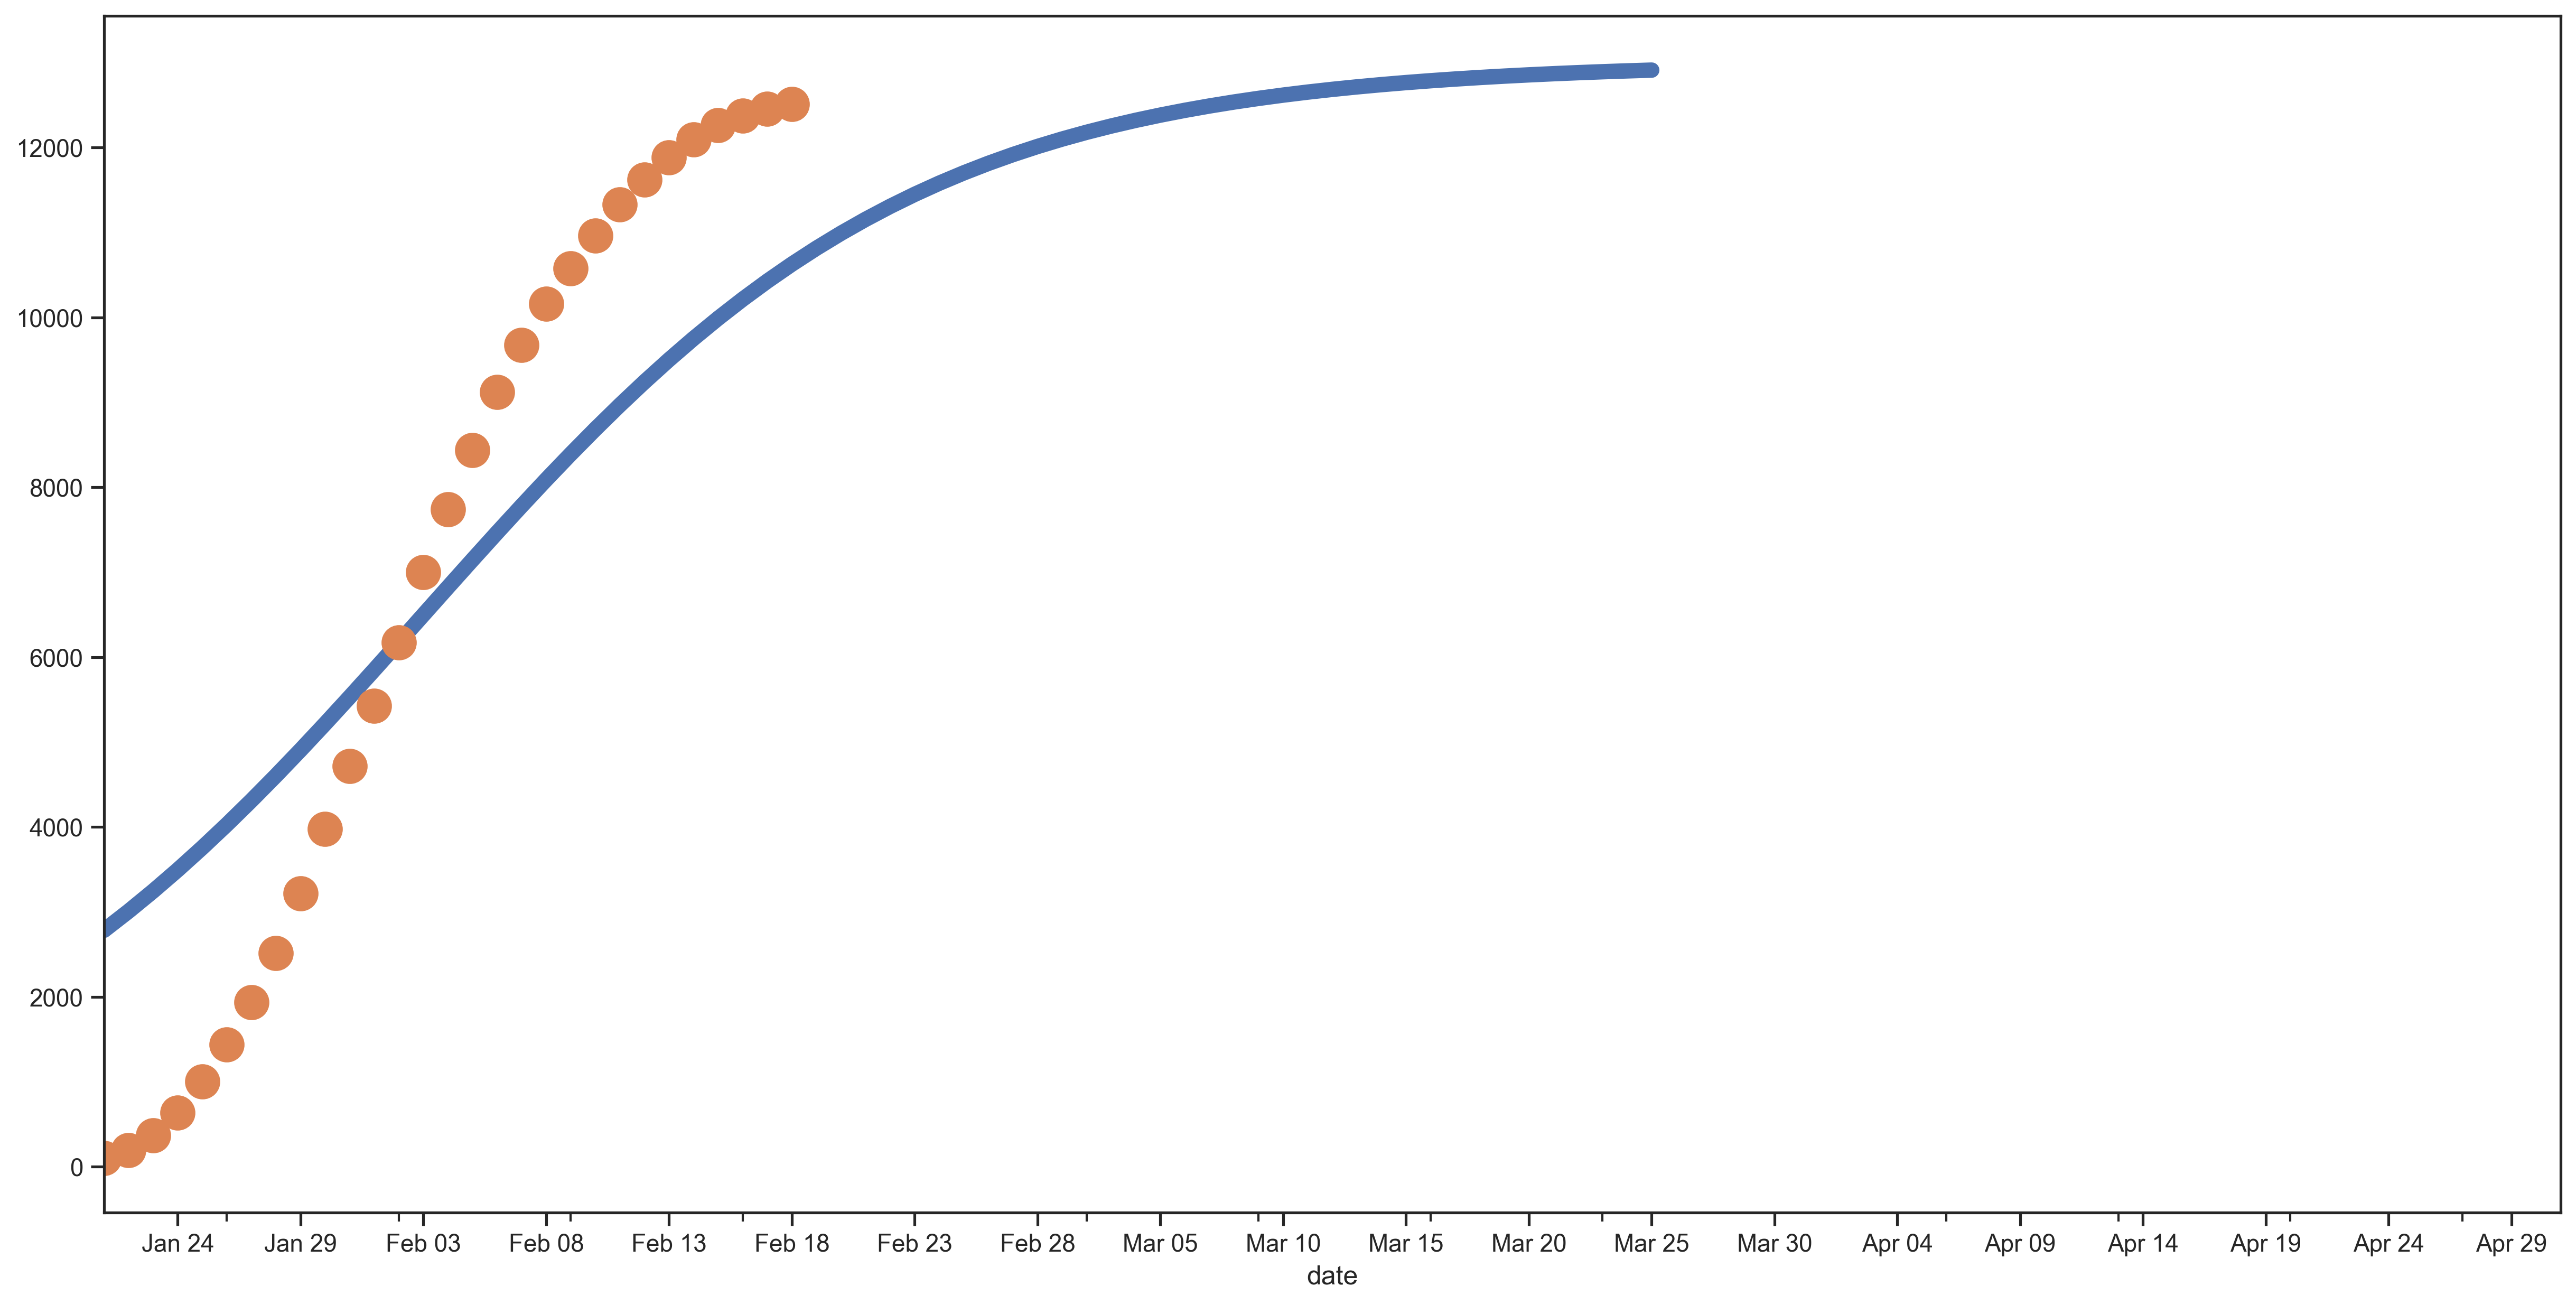

In [175]:
import matplotlib.dates as mdates
x = np.linspace(-day_range, day_range, day_range*2+1)
index_sig = pd.date_range('2020-01-22', periods= day_range*2+1)
X_sigmoid = pd.Series(sigmoid(x, 0.1) * max_cases)
X_sigmoid.index = index_sig
ax = X_sigmoid.shift(-37).plot(figsize=(20,10), linewidth=7)
X_non_hub.plot(style='o', ms=15)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

#plt.gcf().autofmt_xdate()